In [3]:
# ---
# ### 1.2 加载预训练的Faster R-CNN模型
# 
# `torchvision.models` 模块中包含了许多预训练好的模型，我们可以直接加载一个在COCO数据集上训练完毕的Faster R-CNN模型。
# 
# *   **说明**: `pretrained=True` 会自动下载模型的权重。该模型可以识别COCO数据集中包含 "bicycle" 在内的80个类别。我们将使用 `ResNet-50` 作为其骨干网络（Backbone）来进行特征提取。
# ---

import torchvision
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights

# 加载预训练模型
# weights 参数指定了我们用哪个版本的预训练权重，V2是更新、性能更好的版本
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

# 将模型设置为评估模式
model.eval()

print("模型加载成功！")

模型加载成功！


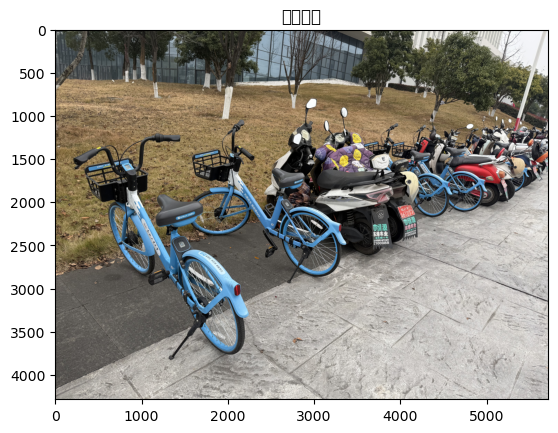

In [5]:
# ---
# ### 2.1 准备测试图片与数据预处理
# 
# 为了将图片送入模型，我们需要进行一些预处理，包括：
# 1.  读取图片。
# 2.  将图片从OpenCV的BGR格式转为RGB格式。
# 3.  将图片转换为PyTorch的Tensor格式。
# 
# *   **操作指南**: 请先准备一张包含共享单车的图片，例如命名为 `test_bike.jpg` 并上传到Jupyter Notebook的当前工作目录。
# ---

import cv2
import torch
from torchvision import transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# 准备图片预处理流程
transform = T.Compose([T.ToTensor()])

# 请将 'test_bike.jpg' 替换为你的图片路径
try:
    img_path = 'test_bike1.jpg'
    image = Image.open(img_path).convert("RGB")
    img_tensor = transform(image)
except FileNotFoundError:
    print("错误：请上传一张名为 'test_bike.jpg' 的图片到当前目录，或修改 img_path 变量。")
    image = None

if image:
    plt.imshow(image)
    plt.title("原始图片")
    plt.show()

# COCO数据集的类别名称
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

检测完成！


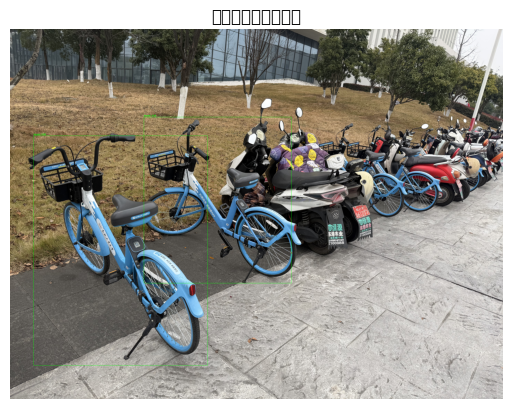

In [6]:
# ---
# ### 2.2 执行检测并可视化结果
# 
# 我们将图片Tensor输入模型，模型会输出检测到的每个物体的边界框、标签和置信度分数。
# 
# *   **说明**: 我们只筛选出 "bicycle" 类别且置信度高于某个阈值（如0.8）的结果进行可视化。
# ---

if image:
    with torch.no_grad():
        # 模型需要一个batch的图片作为输入，所以我们增加一个维度
        prediction = model([img_tensor])

    # --- 结果解析与可视化 ---
    pred_boxes = prediction[0]['boxes'].detach().cpu().numpy()
    pred_scores = prediction[0]['scores'].detach().cpu().numpy()
    pred_labels = prediction[0]['labels'].detach().cpu().numpy()

    # 将PIL Image转为OpenCV格式用于绘图
    img_cv = np.array(image)
    img_cv = cv2.cvtColor(img_cv, cv2.COLOR_RGB2BGR)

    CONF_THRESHOLD = 0.8
    BICYCLE_CLASS_ID = COCO_INSTANCE_CATEGORY_NAMES.index('bicycle')

    for i in range(len(pred_scores)):
        score = pred_scores[i]
        label_id = pred_labels[i]
        
        # 筛选我们感兴趣的类别和高置信度的结果
        if label_id == BICYCLE_CLASS_ID and score > CONF_THRESHOLD:
            box = pred_boxes[i]
            x1, y1, x2, y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
            
            # 绘制边界框
            cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            # 绘制标签和置信度
            label_text = f"{COCO_INSTANCE_CATEGORY_NAMES[label_id]}: {score:.2f}"
            cv2.putText(img_cv, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    print("检测完成！")
    # 将BGR转回RGB用于matplotlib显示
    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.title("预训练模型检测结果")
    plt.axis('off')
    plt.show()

In [ ]:
# ---
# ### 3.1 微调的必要性与数据准备
# 
# 正如我们可能在上面的结果中看到的，预训练模型能识别“自行车”，但它不认识“哈啰单车”这个具体子类。为了让模型专门识别哈啰单车并适应校园环境，我们需要用一个标注好的、包含哈啰单车的数据集来**微调**模型。
# 
# **数据准备流程**:
# 1.  **收集与划分**: 收集校园内的哈啰单车图片，并划分为训练集（train）和验证集（val）。
# 2.  **数据标注**: 使用`LabelImg`等工具进行标注，保存为Pascal VOC XML格式。每个XML文件包含图片中所有哈啰单车的边界框坐标和类别名称（例如 "HaroBike"）。
# 3.  **创建自定义Dataset**: 在PyTorch中，我们需要创建一个继承自 `torch.utils.data.Dataset` 的类，用于加载我们的图片和标注信息。
# 
# *   **说明**: 下面的代码块是一个完整的、用于微调的源代码示例，包括了自定义Dataset、模型修改和训练循环。**要运行此代码，您必须先准备好自己的数据集。**
# ---

# 这是一个完整的微调脚本框架，在实际操作时，通常会保存为一个 .py 文件来执行
# 为了在Jupyter中展示，我把它放在一个代码块里
# !!! 注意：直接运行此代码块会报错，因为它依赖于一个你尚未创建的数据集 !!!

import os
import xml.etree.ElementTree as ET
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# --- 1. 自定义数据集类 ---
class HaroBikeDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = sorted(list(os.listdir(os.path.join(root, "images"))))
        self.annots = sorted(list(os.listdir(os.path.join(root, "annotations"))))
        # 我们的类别：0是背景，1是HaroBike
        self.classes = {'__background__': 0, 'HaroBike': 1}

    def __getitem__(self, idx):
        # 加载图片
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")

        # 加载标注文件
        annot_path = os.path.join(self.root, "annotations", self.annots[idx])
        tree = ET.parse(annot_path)
        root_xml = tree.getroot()
        
        boxes = []
        labels = []
        for obj in root_xml.findall('object'):
            name = obj.find('name').text
            labels.append(self.classes[name])
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        if self.transforms is not None:
            img = self.transforms(img)
            
        return img, target

    def __len__(self):
        return len(self.imgs)

# --- 2. 获取微调模型 ---
def get_model_for_finetuning(num_classes):
    # 加载预训练模型
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
    # 获取分类器的输入特征数
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # 替换预训练的头部
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# --- 3. 训练流程 ---
def main_train():
    # 检查是否有GPU
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # 我们的数据集只有2个类 (背景 + 哈啰单车)
    num_classes = 2
    
    # 准备数据集 (请将'path/to/your/dataset'替换为你的数据集路径)
    # 假设你的数据集目录结构为:
    # dataset/
    #   ├── train/
    #   │   ├── images/ (*.jpg)
    #   │   └── annotations/ (*.xml)
    #   └── val/
    #       ...
    
    # 定义数据变换
    data_transform = T.Compose([T.ToTensor()])
    
    try:
        dataset_train = HaroBikeDataset('path/to/your/dataset/train', transforms=data_transform)
        # collate_fn 是 DataLoader 的一个重要参数，用于处理不同图片目标数不同的情况
        data_loader_train = DataLoader(dataset_train, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
    except Exception as e:
        print(f"无法加载数据集，请确保路径和结构正确。错误: {e}")
        return

    # 获取模型
    model = get_model_for_finetuning(num_classes)
    model.to(device)

    # 定义优化器
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

    num_epochs = 10

    print("开始训练...")
    for epoch in range(num_epochs):
        model.train()
        for images, targets in data_loader_train:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # 计算损失
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            
            # 反向传播
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {losses.item()}")

    print("训练完成！")
    # 保存模型
    torch.save(model.state_dict(), 'harobike_detector.pth')


# 如果你准备好了数据集，可以取消下面的注释来运行训练
# main_train()
print("微调代码框架已定义。请准备数据集并取消注释以开始训练。")